<div style="text-align: center;">
    <span style="font-family: Georgia; font-size: 32px;">
         A VLE for the Open University
    </span>
</div>

<div style="text-align: right;">
    <span style="font-family: Georgia; font-size: 11px;color: red;">
    Date: 13, Dec, 2025
</div>

<span style="font-family: Georgia; font-size: 20px;">
    
Important questions to be answered in this analysis is as follows:  
    
1- Is the VLE improving students' grades?  

2- Can we predict students' grades?</span>

## Step 1: Importing Required Python Libraries and Reading Dataset

In [1]:
import seaborn
import pandas as pd
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import pearsonr, PermutationMethod, normaltest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector

import warnings

In [3]:
warnings.filterwarnings('ignore')

#### 1-1 : Versions of all the packages use in this report

In [5]:
# Print versions
import scipy
import sklearn
print(f"seaborn: {sns.__version__}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"statsmodels: {sm.__version__}")
print(f"scipy: {scipy.__version__}")
print(f"scikit-learn: {sklearn.__version__}")

seaborn: 0.13.2
pandas: 2.2.2
numpy: 1.26.4
matplotlib: 3.8.4
statsmodels: 0.14.2
scipy: 1.13.1
scikit-learn: 1.4.2


In [7]:
pd.set_option('display.max_columns', None) # I want to see all the columns in merged datasets (not truncated)

### 1-1: Reading Dataset from a path on the system

Defining a __Function__ for reading the data set 

In [9]:
def read_data(name_dir):
    """This function reads all CSV files in a given folder and returns dataframes
    - "name_dir" is a string containing the location of the directory of the dataset (e.g., "DataScienceResearchMethods/Report2/data/"),
    - Function is returning the dataframes associated to the assignment. 
    - You just need to change "name_dir" to match where the data is saved on your computer"""
    DataFrames = {}
    for csv_file in os.listdir(name_dir):
        if csv_file.endswith('.csv'): 
            csv_path  = os.path.join(name_dir, csv_file)
            df = pd.read_csv(csv_path)
            df_name = os.path.splitext(csv_file)[0]
            DataFrames[df_name] = df
    for name, df in DataFrames.items():
        print(f"DataFrame Name: {name}")
    return DataFrames

Please change the **file directory** according to related csv file location in your system

In [11]:
######################################################################################################################################################
''' please change the file location inside brackets according to your system '''
DataFrames = read_data(r"C:/Users/F/Downloads/OULAD")   #   read_data (r"file path goes here")
                                                     
######################################################################################################################################################

#Separating tables from loaded dictionary of csv files (output of read_data() function is a dictionary of DataFrames )
assessments = DataFrames['assessments']
courses = DataFrames['courses']
student_assessment = DataFrames['studentAssessment']
student_info = DataFrames['studentInfo']
student_registration = DataFrames['studentRegistration']
student_vle = DataFrames['studentVle']
vle = DataFrames['vle']

DataFrame Name: assessments
DataFrame Name: courses
DataFrame Name: studentAssessment
DataFrame Name: studentInfo
DataFrame Name: studentRegistration
DataFrame Name: studentVle
DataFrame Name: vle


1- Table **student_info**  can be linked to **student_assessment**, **student_vle** and **student_registration** tables using column ___id_student___.  
2- Table **courses** links to the **assessments**, **student_registration**, **vle** and **student_info** using identifier columns ___code_module__ and ___code_presentation___.  
3- The **assessments** table links to **student_assessment** using **id_assessment** and **vle** to **student_vle** using ___id_site___. [1]

## Step 2: Data cleaning and wrangling

I checked all the summary statistics to find Nans and anomalies.  
For the ease of reading this notebook I decided not to print out unintresting summary results.

### 2-1: student_assessment dataset

In [13]:
#student_assessment.describe() #NOTHING INTERESTING DETECTED
student_assessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id_assessment   173912 non-null  int64 
 1   id_student      173912 non-null  int64 
 2   date_submitted  173912 non-null  int64 
 3   is_banked       173912 non-null  int64 
 4   score           173912 non-null  object
dtypes: int64(4), object(1)
memory usage: 6.6+ MB


The score column  in the studentAssessment table contains some items indicated as __'?'__ , which amount to 173 rows. There is only a few of these NaNs across this feature (173 compared to 173912 rows), therefore for calculating score for score analysis I decided to remove these NaNs.

#### 2-1-1 : Removing NaNs from 'score' column and changing 'date' Dtype to float

In [15]:
print(f" Number of rows in student_assessment table with 'score'=='?', is {len(student_assessment[student_assessment['score']=='?'])}")

#removing Nans from score column
student_assessment = student_assessment[student_assessment['score']!='?']

#Converting the DataType of scores to float.
student_assessment['score'] = student_assessment['score'].astype(float)
print(f'I changed score column data type from object to  {student_assessment['score'].dtypes}')

 Number of rows in student_assessment table with 'score'=='?', is 173
I changed score column data type from object to  float64


#### 2-1-2: Removing rows with their score flag being 'is_banked'

In [17]:
student_assessment_notbanked = student_assessment[student_assessment['is_banked']!=1]
print(f'Removing rows with "is_banked==1" leads to almost {(student_assessment_notbanked.shape[0]/student_assessment.shape[0]):0.1f}% loss of data in student assessment table ')
student_assessment = student_assessment_notbanked.drop(columns = ['is_banked'] ) 
del student_assessment_notbanked  #to free up memory, not keeping intermediate files 

Removing rows with "is_banked==1" leads to almost 1.0% loss of data in student assessment table 


### 2-2: Assessment dataset

In [19]:
#student_assessment.describe()
assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               206 non-null    object 
 5   weight             206 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 9.8+ KB


In [21]:
assessments[assessments['date']=='?'].count()

code_module          11
code_presentation    11
id_assessment        11
assessment_type      11
date                 11
weight               11
dtype: int64

#### Handling NaNs related to 'date's of Exams (with "module_presentation_length")

In [23]:
# Merging 'assessments' and 'courses' tables to find the related module_presentation_length and put it as date for exam dates that are not 
# provided in table  (dates that are presented as '?'s)
unknown_dates = len(assessments[assessments['date']=='?'])
print(f" Number of rows in assessments table with 'date'=='?', is {unknown_dates} rows")


merged_1 = assessments.merge(courses, on=["code_module", "code_presentation"], how="left")

#sunbtituting NaNs
assessments.loc[(assessments["date"] == "?") & (assessments["assessment_type"] == "Exam"), "date"] = merged_1.loc[(assessments["date"] == "?") & (assessments["assessment_type"] == "Exam"), "module_presentation_length"]

#change the datatype of 'date' from object to int ('date feature is in days')
assessments['date']= assessments['date'].astype(int)

unknown_dates = len(assessments[assessments['date']=='?'])
print(f" Number of rows in assessments table with 'date'=='?', is {unknown_dates} rows")

 Number of rows in assessments table with 'date'=='?', is 11 rows
 Number of rows in assessments table with 'date'=='?', is 0 rows


Data type of 'date' column is object, and further investigation in next parts shows they are related to Exam type assessments.

### 2-2-1: Merging assessments table and student_assessment (assessment_type = 'Exam' is problematic)

In [25]:
#checking missing keys in assessments table and student_assessment
merged = assessments.merge(student_assessment, on='id_assessment', how='left', indicator=True)
missing_keys = merged[merged['_merge'] == 'left_only']['id_assessment']
if not missing_keys.empty:
    print("Missing keys:", missing_keys.tolist())
else:
    print("All keys in assessments table are present in student_assessment")

Missing keys: [1757, 1763, 14990, 15002, 15014, 15025, 40087, 40088, 30713, 30718, 30723, 34872, 34885, 34898, 34911, 37424, 37434, 37444]


In [27]:
filtered_assessments = assessments[assessments['id_assessment'].isin(missing_keys)]
print(f'These missing keys are related to assessment_type {filtered_assessments['assessment_type'].unique()}')

These missing keys are related to assessment_type ['Exam']


In subsection 2-2-4 it has been described how to handle assessment_type==['Exam'] issue.

In [29]:
# (The assessments table links to student_assessment using id_assessment)
assessment_merged = student_assessment.merge(assessments, on='id_assessment', how = 'inner')

#### 2-2-2: Creating columns for different assessment types scores

In [31]:
# There is only have three types of assessments, here separate columns created for them  
assessment_merged['Exam_score'] = assessment_merged['score'].where(assessment_merged['assessment_type'] == 'Exam', 0)
assessment_merged['CMA_score'] = assessment_merged['score'].where(assessment_merged['assessment_type'] == 'CMA', 0)
assessment_merged['TMA_score'] = assessment_merged['score'].where(assessment_merged['assessment_type'] == 'TMA', 0)

#### 2-2-3: Creating 'weighted_score' column

In [33]:
# creat a column named 'weighted_score' that is the multiplication of related assessment score and its weight
assessment_merged['weighted_score']= assessment_merged['score']*assessment_merged['weight']/100

In [35]:
assessment_merged.head(1)

,id_assessment,id_student,date_submitted,score,code_module,code_presentation,assessment_type,date,weight,Exam_score,CMA_score,TMA_score,weighted_score
0,1752,11391,18,78.0,AAA,2013J,TMA,19,10.0,0.0,0.0,78.0,7.8


#### 2-2-4: Removing 'Exam' assessments, (only considering TMA and CMA assessments for calculating final score)

In [35]:
# assessment types that are categorized as EXAM need careful handling as their weight calculated based on 100%, separted from other types of assessment

assessment_merged[assessment_merged['assessment_type']=='Exam'].code_module.unique() 

array(['CCC', 'DDD'], dtype=object)

Based on descriptions on [Open university website](https://analyse.kmi.open.ac.uk/open_dataset) about **weight** of the assessment in % in the dataset it is mentioned that __"Typically, Exams are treated separately and have the weight 100%; the sum of all other assessments is 100%.__ so if I multiply each score with related weight and sum them up for 'CCC', 'DDD' modules  I will get sum of scores for each students that is calculated from 200. (100 for sum(TMA and CMA) and 100 for Exam). Also, in previous sections it was shown that some of the keys in assessment table are missing in student_assessment table. Therefore, only weighted score out of TMA and CMA scores was considered in this report. [3]  
Also in the EDA section it was detected that no weights (neighther Exam nor TMA and CMA) for module GGG was recorded.

In [37]:
assessment_merged = assessment_merged[assessment_merged['assessment_type'] != 'Exam']

#### 2-2-6: Creating a new feature realated to timeliness in submitting assignments (avg_timliness)

date column in assessments.csv gives information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero).  
date_submitted column in studentAssessment.csv is the date of student submission, measured as the number of days since the start of the module presentation.  
now we creat a new column named **submission_timeliness** that if it is positive means student submitted assignmnet without delays, and if negative shows delays for submission.



In [39]:
assessment_merged['submission_timeliness'] = assessment_merged['date_submitted'] - assessment_merged['date']
assessment_merged['week']=(assessment_merged['date'] // 7)

assessment_merged_visualizaion = assessment_merged.copy()
#removing 'date_submitted' and 'date' columns from Assessment table. (not needed any more)

assessment_merged.drop(columns=['date_submitted', 'date'], inplace=True)

Now, we take the sum of weighted_score realated to each student in each module and presentation and average of submission_timeliness realting to those.

In [41]:
assessment_merged = (assessment_merged.groupby(['code_module', 'code_presentation', 'id_student'])
                                      .agg(final_score=('weighted_score', 'sum'),avg_timeliness=('submission_timeliness', 'mean'))
                                      .reset_index())
assessment_merged['avg_timeliness'] = assessment_merged['avg_timeliness'].round(2)
assessment_merged.head(3)

,code_module,code_presentation,id_student,final_score,avg_timeliness
0,AAA,2013J,11391,82.4,-1.8
1,AAA,2013J,28400,65.4,0.0
2,AAA,2013J,31604,76.3,-2.0


### 2-3: The vle dataset

In [43]:
#vle.decribe() #Nothing particular worth highlighting detected 
vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id_site            6364 non-null   int64 
 1   code_module        6364 non-null   object
 2   code_presentation  6364 non-null   object
 3   activity_type      6364 non-null   object
 4   week_from          6364 non-null   object
 5   week_to            6364 non-null   object
dtypes: int64(1), object(5)
memory usage: 298.4+ KB


#### 2-3-1: Removing 'week_from' and 'week_to' column

In [45]:
# in vle table, week_from shows the week from which the material is planned to be used.
# in vle table, week_to shows week until which the material is planned to be used.
print(f'number of null values in week_from column in vle table is {vle[vle['week_from']=='?'].week_from.count()}') 
print(f'number of null values in week_to column in vle table is {vle[vle['week_to']=='?'].week_to.count()}') 

# week_from and week_to are almost empty columns, 5243 out of 6364 are nulls. I assumed these two features are not important for my analysis, 
# so I removed week_from and week_to columns 
vle = vle.drop(columns = ['week_from', 'week_to'])

number of null values in week_from column in vle table is 5243
number of null values in week_to column in vle table is 5243


In [47]:
# because we have 'code_module','code_presentation' in student_vle table 
#I removed these two column from vle as they are redundant
VLE=vle.drop(columns=['code_module','code_presentation']) # I need vle dataset for visulization in EDA part

# and also checked for the duplicated id_sites to make sure it acts as a key perfectly
VLE.id_site.duplicated().sum()

0

### 2-4: The student_vle dataset

In [ ]:
#student_vle.info() # very important table for our analysis, 10655279 rows
#student_vle.describe() #NOTHING VERY INTERESTING DETECTED, so I dont show the output

### 2-4-2 merging vle and student_vle

In [49]:
# vle linked to studentVle using id_site
vle_merged = VLE.merge(student_vle, on=['id_site'], how='inner') 

del VLE  #to free up memory space, I removed this temporary intermediate file

#### 2-4-3: Create new feature: avearge weekly clicks and total sum_clicks for each student/mosule/presentation/activity_type

using features that are time_series not used in the analysis. So while grouping based on id_student/code_module/code_presentation/activity_type to group based on sum or mean  date column lost.

The vle_merged table contains records of students' clicks on different VLE activities over time (in days). first we change date to week :

The date column in vle_merged shows days since the start of the course. Dividing date(days from registration) by 7 (date // 7) groups the data into weeks.  
__Assumption:__ The date // 7 shows that day 0 is the first recorded activity and is part of the first week of the course. This is a simple assumption to reach the week grouping process and doesn't necessarily aligns with the usual calendar week that starts from monday to Sunday.
Then sum_click by week gives the total interaction for each week for calculating the mean (sum_click by week and id_student gives per-student weekly averages)

In [51]:
vle_merged['week'] = (vle_merged['date'] // 7)  # doing floor division to extract week number

vle_merged = (vle_merged.groupby(['id_student', 'code_module', 'code_presentation', 'activity_type', 'week'])
                        .agg(sum_click=('sum_click', 'sum'), avg_weekly_clicks =('sum_click', 'mean'))
                        .reset_index())

vle_merged.sample(3)

,id_student,code_module,code_presentation,activity_type,week,sum_click,avg_weekly_clicks
2173591,693182,CCC,2014J,resource,15,3,1.5
1214006,585201,GGG,2013J,subpage,7,2,2.0
2240327,1465407,FFF,2014B,url,8,1,1.0


#### 2-4-4: Creating separate column for sum of clicks for different categories of activity_type  

In [52]:
# creating columns for different categories activity_type, and filling them by related sum_click
# instead of using vle_merged = pd.get_dummies(vle_merged,columns=["activity_type"]) code we first creat activity_columns then concatanet them 
# to merged table, because we need  activity_columns names to itearte over and put related sum_click values in the True cells.

activity_columns = pd.get_dummies(vle_merged['activity_type'])
vle_merged = pd.concat([vle_merged, activity_columns], axis=1)
for col in activity_columns.columns:
    vle_merged[col] = vle_merged['sum_click'] * activity_columns[col] 

vle_merged = vle_merged.drop(columns= ['activity_type'])
vle_merged_visulization = vle_merged.copy() # keep a copy for later visulization

In [54]:
# doing grouping by 'id_student/code_module/code_presentation' based on related aggregation (mean and sum) to reach the desired features 
vle_merged = (vle_merged.groupby(['id_student', 'code_module', 'code_presentation'])
              .agg( sum_click_sum=('sum_click', 'sum'),
                    avg_weekly_clicks_mean=('avg_weekly_clicks', 'mean'),
                    dataplus_clicks=('dataplus', 'sum'),
                    dualpane_clicks=('dualpane', 'sum'),
                    externalquiz_clicks=('externalquiz', 'sum'),
                    folder_clicks=('folder', 'sum'),
                    forumng_clicks=('forumng', 'sum'),
                    glossary_clicks=('glossary', 'sum'),
                    homepage_clicks=('homepage', 'sum'),
                    htmlactivity_clicks=('htmlactivity', 'sum'),
                    oucollaborate_clicks=('oucollaborate', 'sum'),
                    oucontent_clicks=('oucontent', 'sum'),
                    ouelluminate_clicks=('ouelluminate', 'sum'),
                    ouwiki_clicks=('ouwiki', 'sum'),
                    page_clicks=('page', 'sum'),
                    questionnaire_clicks=('questionnaire', 'sum'),
                    quiz_clicks=('quiz', 'sum'),
                    repeatactivity_clicks=('repeatactivity', 'sum'),
                    resource_clicks=('resource', 'sum'),
                    sharedsubpage_clicks=('sharedsubpage', 'sum'),
                    subpage_clicks= ('subpage', 'sum'),
                    url_clicks=('url', 'sum'))
              .reset_index())

In [57]:
vle_merged.sample(3)

,id_student,code_module,code_presentation,sum_click_sum,avg_weekly_clicks_mean,dataplus_clicks,dualpane_clicks,externalquiz_clicks,folder_clicks,forumng_clicks,glossary_clicks,homepage_clicks,htmlactivity_clicks,oucollaborate_clicks,oucontent_clicks,ouelluminate_clicks,ouwiki_clicks,page_clicks,questionnaire_clicks,quiz_clicks,repeatactivity_clicks,resource_clicks,sharedsubpage_clicks,subpage_clicks,url_clicks
5071,430002,BBB,2014B,50,3.000000,0,0,0,0,25,0,14,0,0,0,0,0,0,0,0,0,4,0,7,0
5454,445351,DDD,2014J,8,1.375000,0,0,0,0,0,0,6,0,0,2,0,0,0,0,0,0,0,0,0,0
11873,567451,DDD,2013J,1469,2.117019,0,0,16,0,321,0,435,0,4,327,0,67,0,0,0,0,64,0,217,18


#### 2-4-5: Merging assessment_merged and vle_merged_df tables

In [57]:
merged_df = assessment_merged.merge(vle_merged, on=['id_student', 'code_module', 'code_presentation'], how='inner')
merged_df.head(3)

,code_module,code_presentation,id_student,final_score,avg_timeliness,sum_click_sum,avg_weekly_clicks_mean,dataplus_clicks,dualpane_clicks,externalquiz_clicks,folder_clicks,forumng_clicks,glossary_clicks,homepage_clicks,htmlactivity_clicks,oucollaborate_clicks,oucontent_clicks,ouelluminate_clicks,ouwiki_clicks,page_clicks,questionnaire_clicks,quiz_clicks,repeatactivity_clicks,resource_clicks,sharedsubpage_clicks,subpage_clicks,url_clicks
0,AAA,2013J,11391,82.4,-1.8,934,4.531605,0,0,0,0,193,0,138,0,0,553,0,0,0,0,0,0,13,0,32,5
1,AAA,2013J,28400,65.4,0.0,1435,3.071343,10,0,0,0,417,0,324,0,0,537,0,0,0,0,0,0,12,0,87,48
2,AAA,2013J,31604,76.3,-2.0,2158,2.925490,2,0,0,0,634,1,432,0,0,836,0,0,0,0,0,0,19,0,144,90


### 2-5: The courses datset

In [56]:
courses.info() # NOTHING INTERESTING DETECTED, we can add module_presentation length to merged_df
#courses.describe().T 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 660.0+ bytes


#### 2-5-1: Adding content of courses dataset to merged_df  
(our first consolidated merged table from 4 vle, student_vle, assessments, and student_assessment)

In [59]:
merged_df= merged_df.merge(courses, on=['code_module', 'code_presentation'], how='inner' )
merged_df.sample(3)

,code_module,code_presentation,id_student,final_score,avg_timeliness,sum_click_sum,avg_weekly_clicks_mean,dataplus_clicks,dualpane_clicks,externalquiz_clicks,folder_clicks,forumng_clicks,glossary_clicks,homepage_clicks,htmlactivity_clicks,oucollaborate_clicks,oucontent_clicks,ouelluminate_clicks,ouwiki_clicks,page_clicks,questionnaire_clicks,quiz_clicks,repeatactivity_clicks,resource_clicks,sharedsubpage_clicks,subpage_clicks,url_clicks,module_presentation_length
19081,FFF,2013J,529201,63.50,-37.92,1608,2.339917,0,0,0,4,139,0,137,0,0,176,0,2,4,1,837,0,126,0,174,8,268
13502,DDD,2014B,2450650,60.05,-1.20,2191,5.056227,0,0,18,0,174,1003,309,0,7,81,0,48,0,0,0,0,63,0,460,28,241
9369,CCC,2014J,634776,7.28,5.00,362,1.880465,0,0,0,0,17,0,64,0,1,10,0,0,0,0,110,0,132,0,26,2,269


### 2-6: The student_info dataset

In [65]:
student_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              32593 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


#### 2-6-1: Removing sensetive features from student_info table

In [61]:
#To make the analysis simpler and unbiased,  gender, region, imd_band and disability features are NOT used in the analysis. 
# Instead, analysis focus is on academic and interaction data.

student_info_c = student_info[['code_module', 'code_presentation', 'id_student','highest_education',
                               'age_band', 'num_of_prev_attempts','studied_credits', 'final_result']]
student_info_c.head(3)

,code_module,code_presentation,id_student,highest_education,age_band,num_of_prev_attempts,studied_credits,final_result
0,AAA,2013J,11391,HE Qualification,55<=,0,240,Pass
1,AAA,2013J,28400,HE Qualification,35-55,0,60,Pass
2,AAA,2013J,30268,A Level or Equivalent,35-55,0,60,Withdrawn


#### 2-6-2: One-Hot coding for highest_eduacation and age_band

In [63]:
student_info_c= pd.get_dummies(student_info_c,columns=['highest_education', 'age_band' ])#drop_first= False, I need them for visulization
student_info_c.sample(3)

,code_module,code_presentation,id_student,num_of_prev_attempts,studied_credits,final_result,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,age_band_0-35,age_band_35-55,age_band_55<=
28425,FFF,2014J,615301,0,60,Pass,True,False,False,False,False,True,False,False
19433,EEE,2013J,266915,0,60,Withdrawn,False,False,True,False,False,False,True,False
31277,GGG,2014B,608649,0,30,Withdrawn,False,False,True,False,False,True,False,False


#### 2-6-3: Merging the student_info_c to merged_df dataset

In [65]:
merged_df= merged_df.merge(student_info_c, on=['id_student','code_module', 'code_presentation'], how='inner' )

#### 2-6-4: Removing rows with final result indicated as 'Withdrawn'

In [67]:
merged_df[merged_df['final_result']=='Withdrawn'][['code_module', 'code_presentation','id_student', 'final_score', 'final_result']].head()

,code_module,code_presentation,id_student,final_score,final_result
14,AAA,2013J,65002,20.2,Withdrawn
21,AAA,2013J,94961,7.4,Withdrawn
28,AAA,2013J,106247,29.3,Withdrawn
40,AAA,2013J,129955,40.1,Withdrawn
43,AAA,2013J,135400,17.4,Withdrawn


Because final score was calculated based on assignnemt scores (Exam scores ignored for the reasons mentioned earlier) for DDD and CCC modules, as a result although the student final_result is withdrawn but we still have a calculated final_score for these modules.
These students with witdrawn status, quited the modules at different dates during the semester(presentation), so their final_score has no value for our modeling. Therefore I removed rows with final_result being showed as Withdrwan.

In [69]:
print(f'size before removing Withdrawal {merged_df.shape}')
merged_df=merged_df[merged_df['final_result']!= 'Withdrawn']
print(f'size after removing Withdrawal {merged_df.shape}')

size before removing Withdrawal (25521, 39)
size after removing Withdrawal (20964, 39)


### 2-7: The student_registration dataset

In [77]:
student_registration.info() # Dtype of date_registration is object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   code_module          32593 non-null  object
 1   code_presentation    32593 non-null  object
 2   id_student           32593 non-null  int64 
 3   date_registration    32593 non-null  object
 4   date_unregistration  32593 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.2+ MB


Because the information in this table may not add value to our analysis it has been decided not to include it.

### 2-8: Final all merged dataset

In [77]:
# merged_df.info() # 20964 entries, total 39 columns, no nulls

In [79]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_student,20964.0,706722.122782,550120.867925,6516.0,508416.500000,589844.000000,642818.000000,2.698588e+06
final_score,20964.0,55.610028,30.380009,0.0,34.126250,64.955000,80.250000,1.000000e+02
avg_timeliness,20964.0,-11.818779,23.953328,-236.0,-14.000000,-0.500000,1.380000,6.900000e+01
sum_click_sum,20964.0,1732.359950,1876.021467,1.0,503.000000,1108.500000,2304.000000,2.413900e+04
avg_weekly_clicks_mean,20964.0,2.921929,0.820738,1.0,2.356994,2.837731,3.372951,3.217844e+01
dataplus_clicks,20964.0,2.242368,8.241343,0.0,0.000000,0.000000,0.000000,1.430000e+02
dualpane_clicks,20964.0,0.919720,3.168892,0.0,0.000000,0.000000,0.000000,6.800000e+01
externalquiz_clicks,20964.0,2.721570,9.702319,0.0,0.000000,0.000000,0.000000,3.400000e+02
folder_clicks,20964.0,0.257298,0.953484,0.0,0.000000,0.000000,0.000000,1.300000e+01
forumng_clicks,20964.0,347.554474,674.289444,0.0,41.750000,147.000000,379.000000,1.315400e+04


##### check for duplicates

In [81]:
merged_df.duplicated().sum()

0

### 2-8-1: Considerations for EDA and modeling (next sections)

1) Looking at counts in merged_df.describe : No further null values detected  
2) Linear regression only works with numeric data (final_result:categorical removed from the dataset)  
3) Features that provide no value like id_student should be removed later  
4) Features with std close to 0 do not vary much and provide little to no information if used in the model (so feature like repeatactivity and sharedsubpage removed)  
5) Visualizations like vilon plots can help us understand data better and decide for further cleaning
6) Features that are not correlated with final_score(target variable) provide little to linear regression so we decide for that on the next part
7) Multicollinearity among features must be checked
8) Outliers and Skewness must be checked: Skewed distributions affect the performance of linear regression. We have to transform or rescale skewed features, and remove extreme outliers.
9) We have to do some statistical tests (i.e, pearsonr, spearmanr, kstest, etc. )

#### 2-8-2: Removing repeatactivity_sum and sharedsubpage_sum features

In [71]:
# checking suspicoius features
merged_df[merged_df['repeatactivity_clicks']!=0]

,code_module,code_presentation,id_student,final_score,avg_timeliness,sum_click_sum,avg_weekly_clicks_mean,dataplus_clicks,dualpane_clicks,externalquiz_clicks,folder_clicks,forumng_clicks,glossary_clicks,homepage_clicks,htmlactivity_clicks,oucollaborate_clicks,oucontent_clicks,ouelluminate_clicks,ouwiki_clicks,page_clicks,questionnaire_clicks,quiz_clicks,repeatactivity_clicks,resource_clicks,sharedsubpage_clicks,subpage_clicks,url_clicks,module_presentation_length,num_of_prev_attempts,studied_credits,final_result,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,age_band_0-35,age_band_35-55,age_band_55<=
19028,FFF,2013J,508942,93.75,-90.67,10818,5.068461,0,4,0,2,2198,5,1793,0,2,1889,0,15,36,10,3741,3,116,0,898,106,268,0,180,Fail,False,False,True,False,False,True,False,False
22334,FFF,2014J,638388,89.25,-59.92,1875,2.852302,0,0,0,0,432,0,257,1,12,414,0,31,5,1,576,2,17,0,112,15,269,0,60,Pass,True,False,False,False,False,True,False,False


In [73]:
# sharedsubpage_sum with mean of almost zero and std close to zero was not considered in model
merged_df.drop(columns = ['repeatactivity_clicks','sharedsubpage_clicks'], inplace=True)

#### 2-8-3: Filter the dataset, and rename some columns 

In [75]:
columns = {"highest_education_A Level or Equivalent" : "A_Level", 
           "highest_education_HE Qualification" : "HE_Qual",
           "highest_education_Lower Than A Level" : "Lower_A_level",
          "highest_education_No Formal quals" : "No_formal",
           "highest_education_Post Graduate Qualification" : "Post_Graduate"
          }

merged_df.rename(columns=columns,inplace=True)
#### 3_11: Removing some features in the final merged dataset that used for visualization but not needed for modeling

merged_df = merged_df.rename(columns={
    'sum_click_sum': 'total_clicks',
    'avg_weekly_clicks_mean': 'avg_week_clicks'})

In [77]:
merged_df_visualization=merged_df.copy() # creat a copy for visualization

## Step 3: Data Exploration

### 3-1: Distribution of modules chosen by students

In [79]:
print(f" Number of unique modules are {merged_df_visualization['code_module'].unique()}")

#The code_presentation feature is code name of the presentation. It consists of the year and "B" for the presentation starting 
# in February and "J" for the presentation starting in October.
print(f" Number of unique presentations are {merged_df_visualization['code_presentation'].unique()}")

unique_combinations = merged_df_visualization.groupby(['code_module', 'code_presentation']).size().reset_index()[['code_module', 'code_presentation']]
print(f" Number of unique module/presentations are {unique_combinations.count()[0]}")


 Number of unique modules are ['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
 Number of unique presentations are ['2013J' '2014J' '2013B' '2014B']
 Number of unique module/presentations are 22


Here first we are going to visualize the distribution of modules chosen by students, then we explore the disturibution of modules-presentation chosen by students.(e.g., EEE-2014J, we have 22 unique modules if we consider the presentation-Feb or Oct start time)

Distribution of Modules Chosen by Students

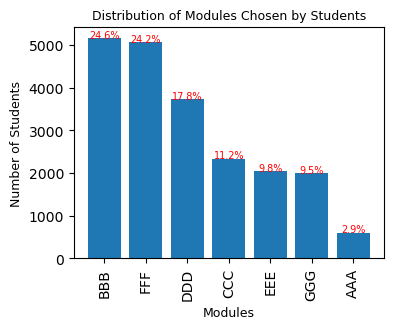

In [81]:
moduls_grouped = (merged_df_visualization.groupby('code_module')['id_student']
                                         .count()
                                         .reset_index()
                                         .rename(columns={'id_student': 'students_counts'}))
                  
total_students = moduls_grouped['students_counts'].sum()

moduls_grouped['percent'] = (moduls_grouped['students_counts'] / total_students) * 100

moduls_grouped = moduls_grouped.sort_values(by='students_counts', ascending=False)

plt.figure(figsize=(4, 3))
plt.bar(moduls_grouped['code_module'], moduls_grouped['students_counts'])

# Add percentile annotations on each bar
for i, (students_count, percent) in enumerate(zip(moduls_grouped['students_counts'], moduls_grouped['percent'])):
    plt.text( x=i,  y=students_count + 1,  s=f"{percent:.1f}%",   ha='center',   fontsize=7,  color='red')  

plt.title('Distribution of Modules Chosen by Students',  fontsize=9)
plt.xlabel('Modules',fontsize=9)
plt.ylabel('Number of Students',fontsize=9)
plt.xticks(ticks=range(len(moduls_grouped)), labels=moduls_grouped['code_module'], rotation=90)  # Rotate x-ticks
plt.show()

Distribution of Modules Chosen by Students Considering the time it has been offered (presented)

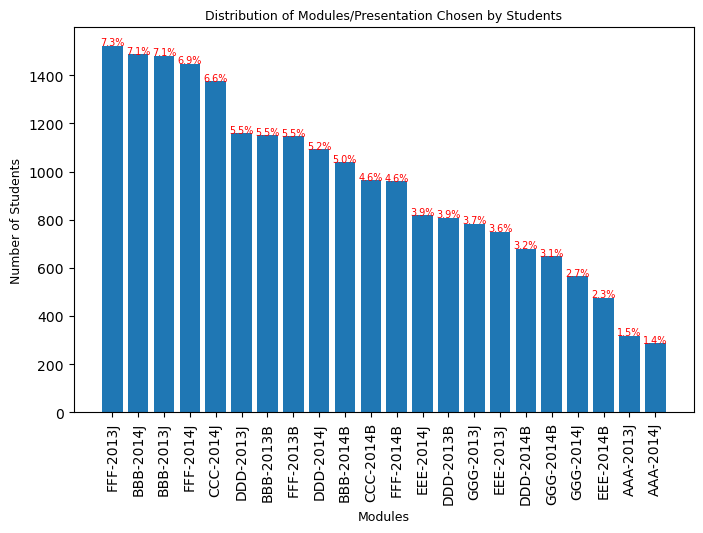

In [83]:
merged_df_visualization['code_module_presentation'] = merged_df_visualization['code_module'] + '-' + merged_df_visualization['code_presentation']

moduls_grouped_1 = (merged_df_visualization.groupby('code_module_presentation')['id_student']
                                           .count()
                                           .reset_index()
                                           .rename(columns={'id_student': 'students_counts'}))

total_students = moduls_grouped_1['students_counts'].sum()

moduls_grouped_1['percent'] = (moduls_grouped_1['students_counts'] / total_students) * 100

moduls_grouped_1 = moduls_grouped_1.sort_values(by='students_counts', ascending=False)

#plot
plt.figure(figsize=(8, 5))
plt.bar(moduls_grouped_1['code_module_presentation'], moduls_grouped_1['students_counts'])

# Add percentile annotations on each bar
for i, (students_count, percent) in enumerate(zip(moduls_grouped_1['students_counts'], moduls_grouped_1['percent'])):
    plt.text( x=i,  y=students_count + 1,  s=f"{percent:.1f}%",   ha='center',   fontsize=7,  color='red')  

plt.title('Distribution of Modules/Presentation Chosen by Students',  fontsize=9)
plt.xlabel('Modules',fontsize=9)
plt.ylabel('Number of Students',fontsize=9)
plt.xticks(ticks=range(len(moduls_grouped_1)), labels=moduls_grouped_1['code_module_presentation'], rotation=90)  # Rotate x-ticks
plt.show()

#### 3-1-1 : The top 5 modules chosen by students

In [85]:
#top_5_modules students chosen
top_5_modules = moduls_grouped_1.nlargest(5, 'students_counts')
pd.DataFrame(top_5_modules.reset_index(drop=True))

,code_module_presentation,students_counts,percent
0,FFF-2013J,1522,7.260065
1,BBB-2014J,1487,7.093112
2,BBB-2013J,1481,7.064492
3,FFF-2014J,1448,6.907079
4,CCC-2014J,1375,6.558863


#### 3-2: Distribution of modules average score

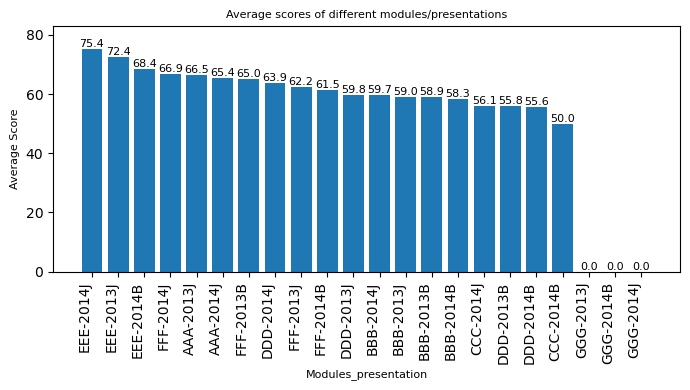

In [87]:
moduls_grouped_2 = merged_df_visualization.groupby('code_module_presentation')['final_score'].mean().reset_index().rename(columns={'final_score': 'Average Score'})\
.sort_values(by='Average Score', ascending=False )

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
bars = ax.bar(moduls_grouped_2['code_module_presentation'], moduls_grouped_2['Average Score'])

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2,   height, f'{height:.1f}', ha='center',  va='bottom',  fontsize=8 )

ax.set_title('Average scores of different modules/presentations', fontsize=8)
ax.set_xlabel('Modules_presentation', fontsize=8)
ax.set_ylabel('Average Score', fontsize=8)
ax.set_ylim(0, moduls_grouped_2['Average Score'].max() * 1.1)  

fig.autofmt_xdate(rotation=90)
plt.tight_layout()
plt.show()


Above bar chart indicates that the average scores for module GGG are zero. In data cleaning and wrangling section, it was described that for calculation consistency we did not considered Exam type assessments for calculating final score. Also it was detected that there are missing keys in student_ssessment dataset that were related to Exam assessments. Further investigation in the assessment table on module GGG shows that TMA and CMA weights are zero, however Exam weights are 100%. However, id_assessments keys related to these Exam weights are missing in the studenet_assessment table.

#### 3-2-2: Removing GGG module from final merged dataset

In [89]:
#checking unique weights for different assessments when module is 'GGG'
assessment_merged_visualizaion[assessment_merged_visualizaion['code_module']== 'GGG']['weight'].unique()

array([0.])

In [91]:
# GGG module information removed from final dataset
merged_df=merged_df[merged_df['code_module']!='GGG']
merged_df_visualization = merged_df_visualization[merged_df_visualization['code_module']!='GGG']

#### 3-2-1: The top 5 modules with the highest average score

In [93]:
top_5_modules_Avg_score = moduls_grouped_2.nlargest(5, 'Average Score').reset_index(drop=True)

print('Top 5 modules with the highest average score are:')
top_5_modules_Avg_score

Top 5 modules with the highest average score are:


,code_module_presentation,Average Score
0,EEE-2014J,75.364683
1,EEE-2013J,72.392277
2,EEE-2014B,68.446303
3,FFF-2014J,66.861188
4,AAA-2013J,66.520376


#### 3-2-3: The top 5 modules with the lowest average score

In [95]:
moduls_grouped_3 = (merged_df_visualization .groupby('code_module_presentation')['final_score']
                                             .mean()
                                             .reset_index()
                                             .rename(columns={'final_score': 'Average Score'})
                                             .sort_values(by='Average Score', ascending=False))

top_5_modules_Avg_score_lowest = (moduls_grouped_3.nsmallest(5, 'Average Score')
                                                  .reset_index(drop=True))

print('Top 5 modules with the lowest average score are:')
top_5_modules_Avg_score_lowest

Top 5 modules with the lowest average score are:


,code_module_presentation,Average Score
0,CCC-2014B,49.963575
1,DDD-2014B,55.611728
2,DDD-2013B,55.803156
3,CCC-2014J,56.131164
4,BBB-2014B,58.285472


### 3-3: Distribution of final results

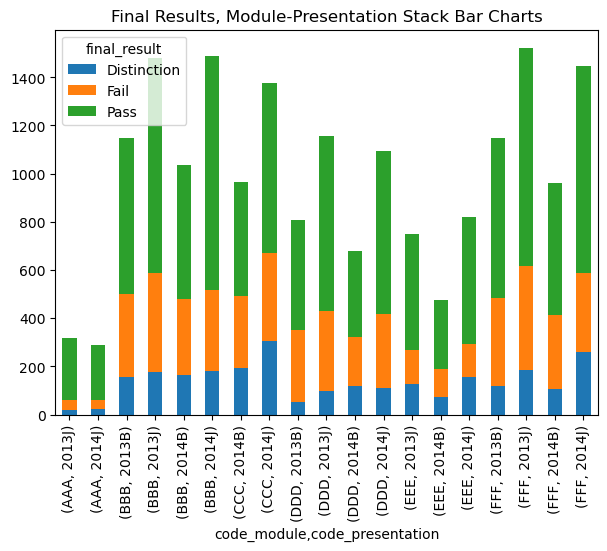

In [97]:
grouped = (merged_df_visualization.groupby(['code_module', 'code_presentation', 'final_result'])
                                  .size()
                                  .unstack())
grouped.plot(kind='bar', 
            stacked=True, 
            title='Final Results, Module-Presentation Stack Bar Charts',
            figsize=(7, 5))

plt.show()

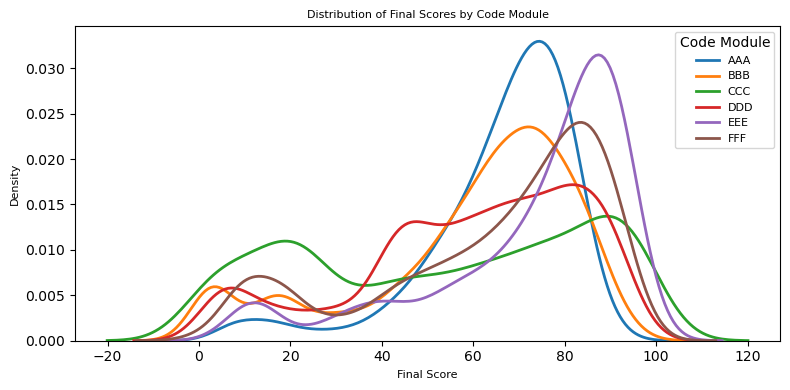

In [99]:
plt.figure(figsize=(8, 4))
for module in merged_df_visualization['code_module'].unique():
    sns.kdeplot(data=merged_df_visualization[merged_df_visualization['code_module'] == module],
                x='final_score',
                label=module,
                linewidth=2 )
plt.title('Distribution of Final Scores by Code Module', fontsize=8)
plt.xlabel('Final Score', fontsize=8)
plt.ylabel('Density', fontsize=8)
plt.legend(title='Code Module', fontsize=8)
plt.tight_layout()



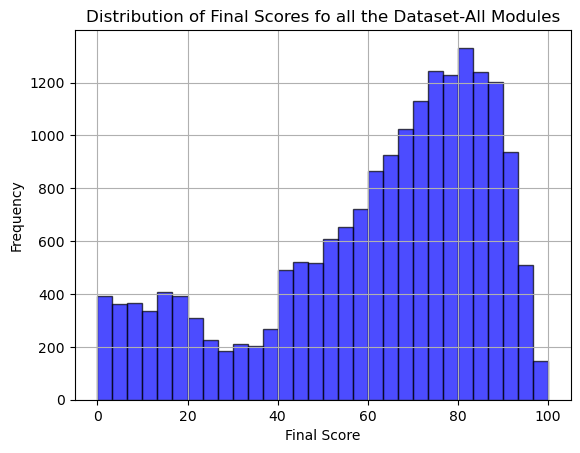

In [101]:
plt.hist(merged_df_visualization['final_score'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Final Scores fo all the Dataset-All Modules')
plt.xlabel('Final Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### 3-3-1 Perform test of normality on final score

In [103]:
#  Kolmogorov-Smirnov test
from scipy.stats import kstest
alpha = 0.05

stat, p_value = kstest(merged_df_visualization['final_score'], 'norm')

print(f"Kolmogorov-Smirnov Test Statistic: {stat}")
print(f"P-value: {p_value}")

if p_value > alpha:
    print("Fail to reject the null hypothesis: The data is normally distributed.")
else:
    print("Reject the null hypothesis: The data is not normally distributed.")

Kolmogorov-Smirnov Test Statistic: 0.9808861019974668
P-value: 0.0
Reject the null hypothesis: The data is not normally distributed.


### 3-4: The top 5 modules with the most number of fails 

In [105]:
moduls_grouped_forfail = (merged_df_visualization.groupby(['code_module_presentation', 'final_result'])['id_student']
                                                 .count()
                                                 .reset_index())

moduls_grouped_forfail = (moduls_grouped_forfail.rename(columns={'id_student': 'student_counts'})[moduls_grouped_forfail['final_result'] == 'Fail']
                                                .nlargest(5, 'student_counts')
                                                .reset_index(drop=True))

print('The top 5 modules with the most number of fails are:')
moduls_grouped_forfail

The top 5 modules with the most number of fails are:


,code_module_presentation,final_result,student_counts
0,FFF-2013J,Fail,428
1,BBB-2013J,Fail,411
2,FFF-2013B,Fail,366
3,CCC-2014J,Fail,363
4,BBB-2013B,Fail,347


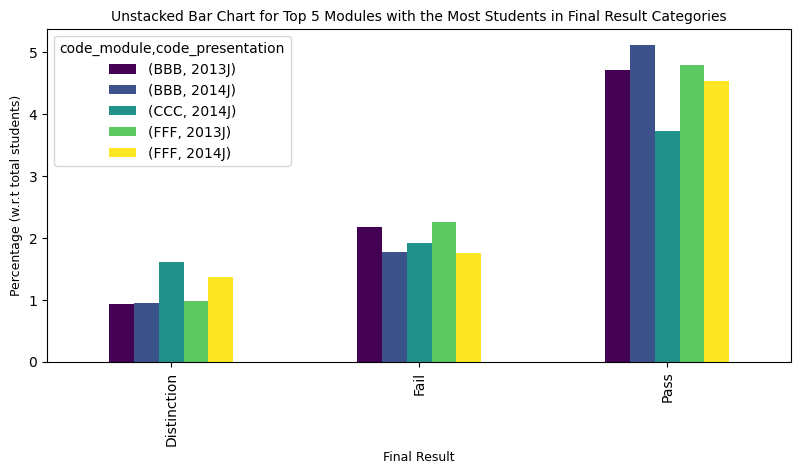

In [107]:
# Group by and calculate percentages
results_group = (merged_df_visualization.groupby(['code_module', 'code_presentation', 'final_result'])['id_student']
                          .count()
                          .reset_index()
                          .rename(columns={'id_student': 'student_counts'})
                          .reset_index(drop=True))

total_students = results_group['student_counts'].sum()
results_group['percent'] = (results_group['student_counts'] / total_students) * 100

# Identify the top 5 modules with the highest number of students
top_modules = (results_group.groupby(['code_module', 'code_presentation'])['student_counts']
                            .sum()
                            .nlargest(5)
                            .index)

# Filter results_group to include only the top 5 modules
results_group_top = results_group[ results_group.apply(lambda row: (row['code_module'], row['code_presentation']) in top_modules, axis=1)]

# Create a pivot table for easier plotting
pivot_table = results_group_top.pivot_table( index = 'final_result', 
                                           columns = ['code_module', 'code_presentation'], 
                                            values = 'percent', 
                                           aggfunc = 'sum')


fig, ax = plt.subplots(nrows=1, ncols=1)

pivot_table.plot( ax=ax,  kind='bar', stacked=False, colormap='viridis')

ax.set_title('Unstacked Bar Chart for Top 5 Modules with the Most Students in Final Result Categories', fontsize=10)
ax.set_xlabel('Final Result', fontsize=9)
ax.set_ylabel('Percentage (w.r.t total students)', fontsize=9)

fig.set_figwidth(fig.get_figwidth() * 1.5)
fig.set_figheight(fig.get_figheight() * 0.9)


### 3-5 : The age distribution of the students

Text(0, 0.5, 'Count')

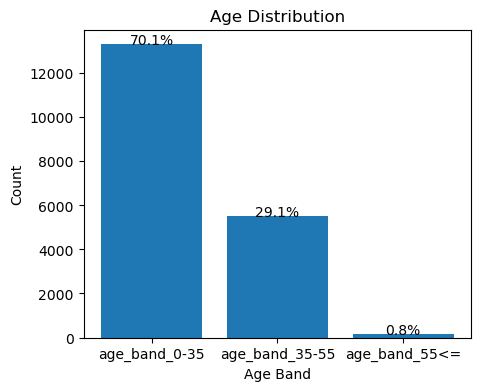

In [109]:
age_bands=merged_df_visualization[['age_band_0-35','age_band_35-55','age_band_55<=']]
age_distribution = age_bands.sum()

# Calculate percentages
total = age_distribution.sum()
percentages = (age_distribution / total) * 100

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(age_distribution.index, age_distribution.values)

for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{percentage:.1f}%', ha='center')


ax.set_title('Age Distribution')
ax.set_xlabel('Age Band')
ax.set_ylabel('Count')


#### removing students with age_band_55<=

In [111]:
merged_df=merged_df.drop(columns=['age_band_55<='])

### 3_6: The weekly activity patterns of the students' interaction with the VLE

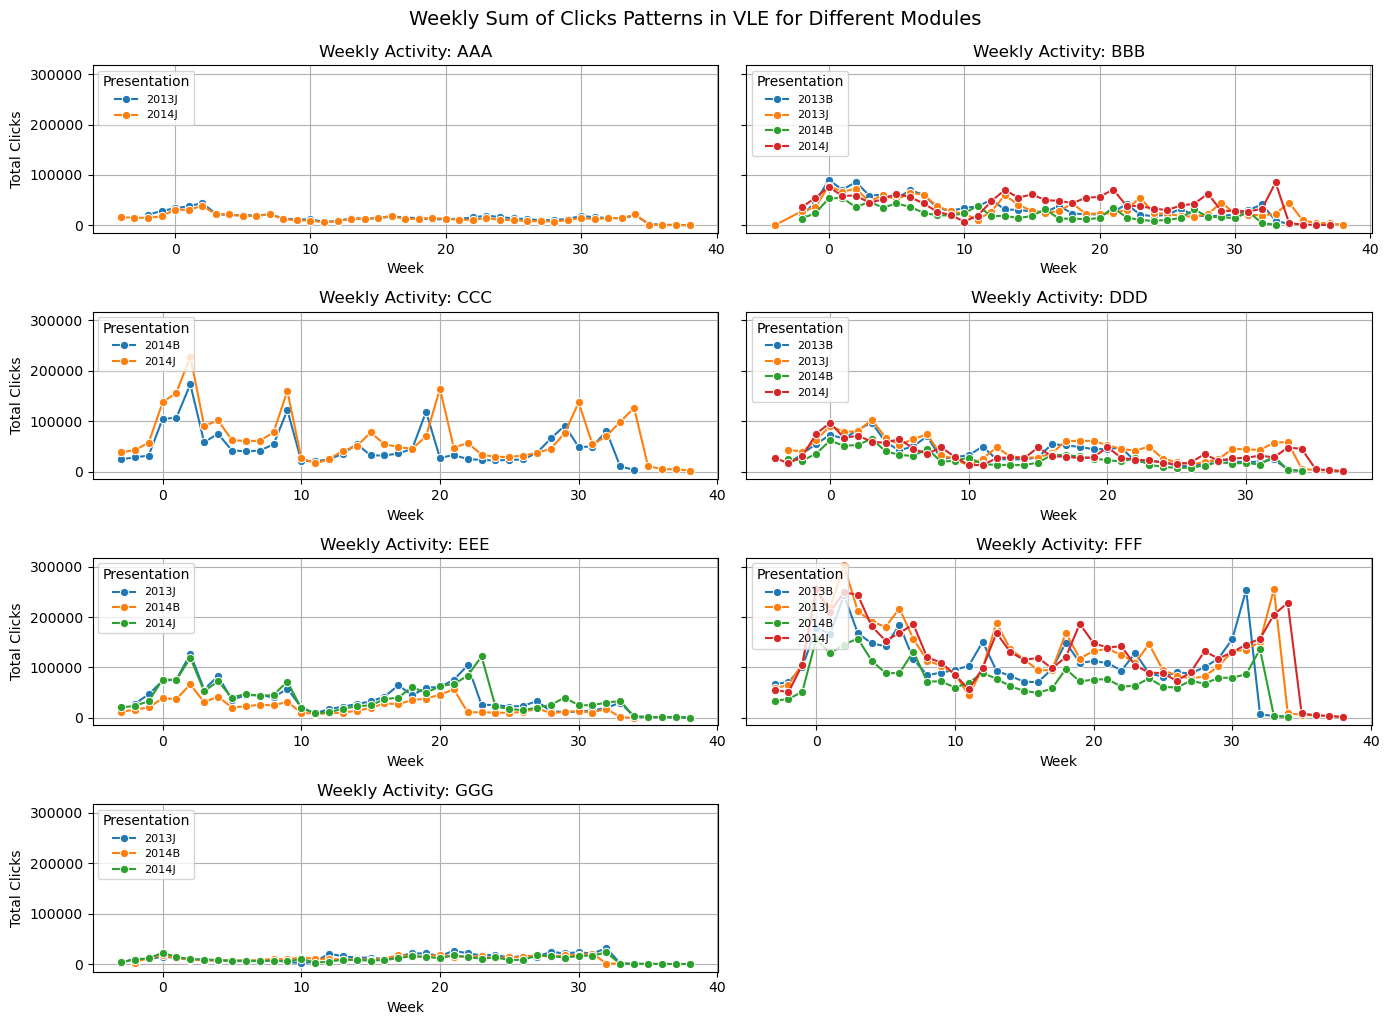

In [113]:
# group the weekly activity patterns
weekly_activity = (vle_merged_visulization.groupby(['code_module', 'code_presentation', 'week'])['sum_click'].sum()
                                            .reset_index()
                                            .rename(columns={'sum_click': 'total_clicks'}))

unique_modules = weekly_activity['code_module'].unique()
num_modules = len(unique_modules)


fig, axes = plt.subplots(nrows=(num_modules // 2 + num_modules % 2), ncols=2, figsize=(14, 10), sharey=True)
axes = axes.flatten() 

# Plotting for weekly patterns for each module/presentation
for idx, (module, group) in enumerate(weekly_activity.groupby('code_module')):
    sns.lineplot(data=group,x='week',y='total_clicks',hue='code_presentation', ax=axes[idx],marker='o' )
    axes[idx].set_title(f'Weekly Activity: {module}', fontsize=12)
    axes[idx].set_xlabel('Week', fontsize=10)
    axes[idx].set_ylabel('Total Clicks', fontsize=10)
    axes[idx].grid(True)
    axes[idx].legend(title='Presentation', fontsize=8, loc='upper left')

# Remove unused axes if there are fewer modules than available subplots
for idx in range(len(unique_modules), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout and add a global title
plt.tight_layout()
plt.suptitle('Weekly Sum of Clicks Patterns in VLE for Different Modules', fontsize=14, y=1.02)

# Show the plot
plt.show()


Text(0.5, 0.98, 'Weekly Click Patterns for Different Activity Types')

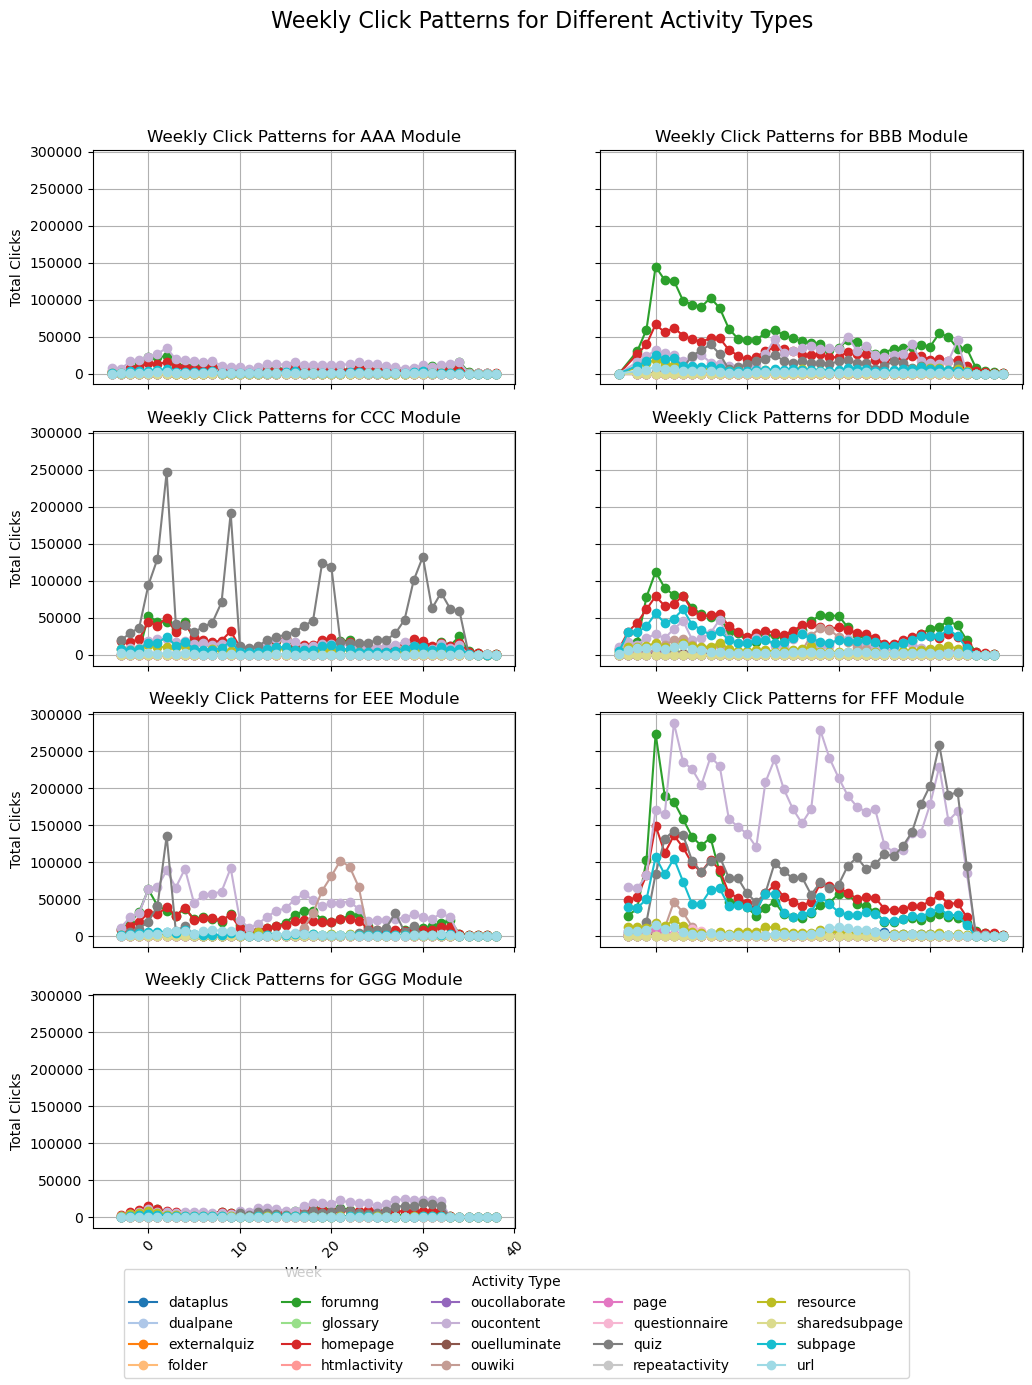

In [115]:
# Group by code_module/code_presentation/week and sum the clicks for each activity type
weekly_clicks = vle_merged_visulization.groupby(['code_module', 'code_presentation', 'week'])[['dataplus', 'dualpane', 'externalquiz', 'folder', 'forumng', 'glossary', 'homepage', 'htmlactivity', 'oucollaborate', 'oucontent', 'ouelluminate', 'ouwiki', 'page', 'questionnaire', 'quiz', 'repeatactivity', 'resource', 'sharedsubpage', 'subpage', 'url']].sum().reset_index()

click_columns = ['dataplus', 'dualpane', 'externalquiz', 'folder', 'forumng', 'glossary', 'homepage', 
                 'htmlactivity', 'oucollaborate', 'oucontent', 'ouelluminate', 'ouwiki', 'page', 
                 'questionnaire', 'quiz', 'repeatactivity', 'resource', 'sharedsubpage', 'subpage', 'url']

# Group by week and calculate the sum of clicks for each column
weekly_clicks = vle_merged_visulization.groupby(['code_module', 'week'])[click_columns].sum()

modules = weekly_activity['code_module'].unique()
num_modules = len(modules)


# Plotting setup: 2 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 14), sharex=True, sharey=True)
axes = axes.flatten()  

# Plotting separately for each module
for idx, module in enumerate(modules):
   
    module_data = weekly_clicks.xs(module, level='code_module')  # Filter data for the current module
    module_data.plot(kind='line', ax=axes[idx], marker='o', colormap='tab20', legend=False)
    axes[idx].set_title(f'Weekly Click Patterns for {module} Module', fontsize=12)
    axes[idx].set_xlabel('Week')
    axes[idx].set_ylabel('Total Clicks')
    axes[idx].grid(True)
    axes[idx].tick_params(axis='x', rotation=45)

# Remove unused axes
for idx in range(len(modules), len(axes)):
    fig.delaxes(axes[idx])

# Add one common legend on top of the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Activity Type', loc='lower center', ncol=5, fontsize=10)

# add a global title

plt.suptitle('Weekly Click Patterns for Different Activity Types', fontsize=16)

#### 3_7: Distribution of total clicks

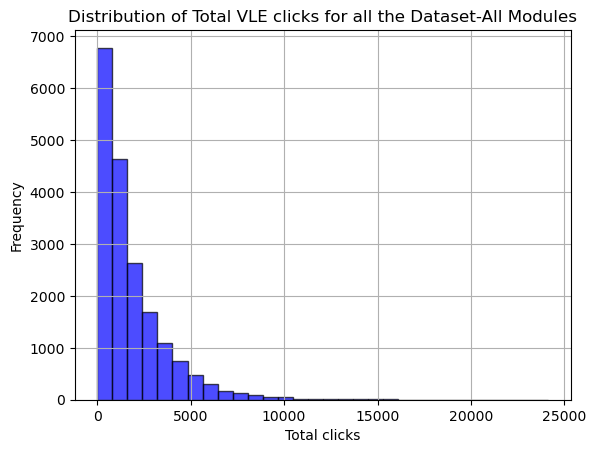

In [117]:
plt.hist(merged_df_visualization['total_clicks'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Total VLE clicks for all the Dataset-All Modules')
plt.xlabel('Total clicks')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### 3_8: Distribution of sum of clicks for VLE activities

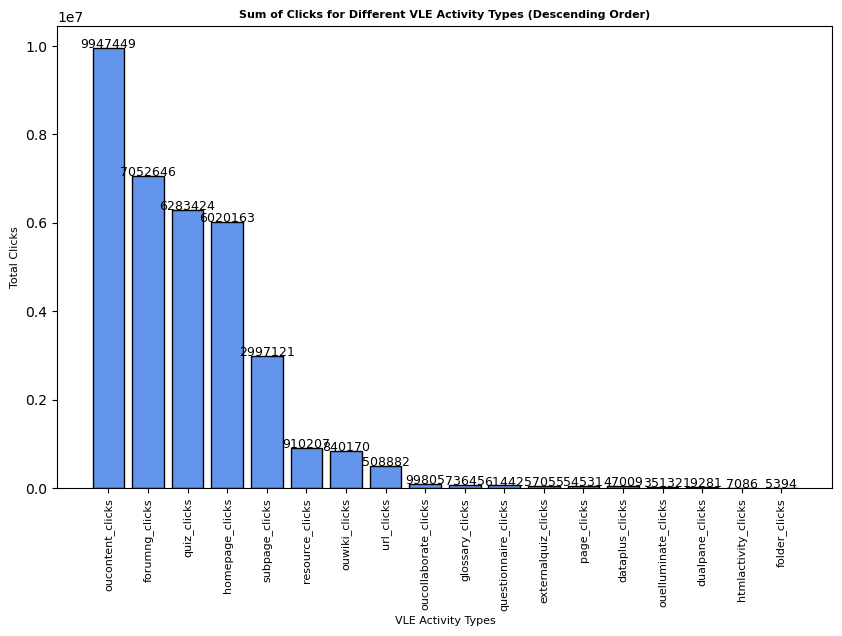

In [119]:
column_sums = merged_df.iloc[:, 7:25].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))  
plt.bar(column_sums.index, column_sums.values, color='cornflowerblue', edgecolor='black')  
plt.xlabel("VLE Activity Types", fontsize=8) 
plt.ylabel("Total Clicks", fontsize=8)
plt.title("Sum of Clicks for Different VLE Activity Types (Descending Order)", fontsize=8, fontweight='bold') 

plt.xticks(rotation=90, fontsize=8)

for i, value in enumerate(column_sums.values):
    plt.text(i, value + 0.5, f"{value:.0f}", ha='center', fontsize=9, color='black')


#### 3_9: Violin plots for all the different features in the dataset

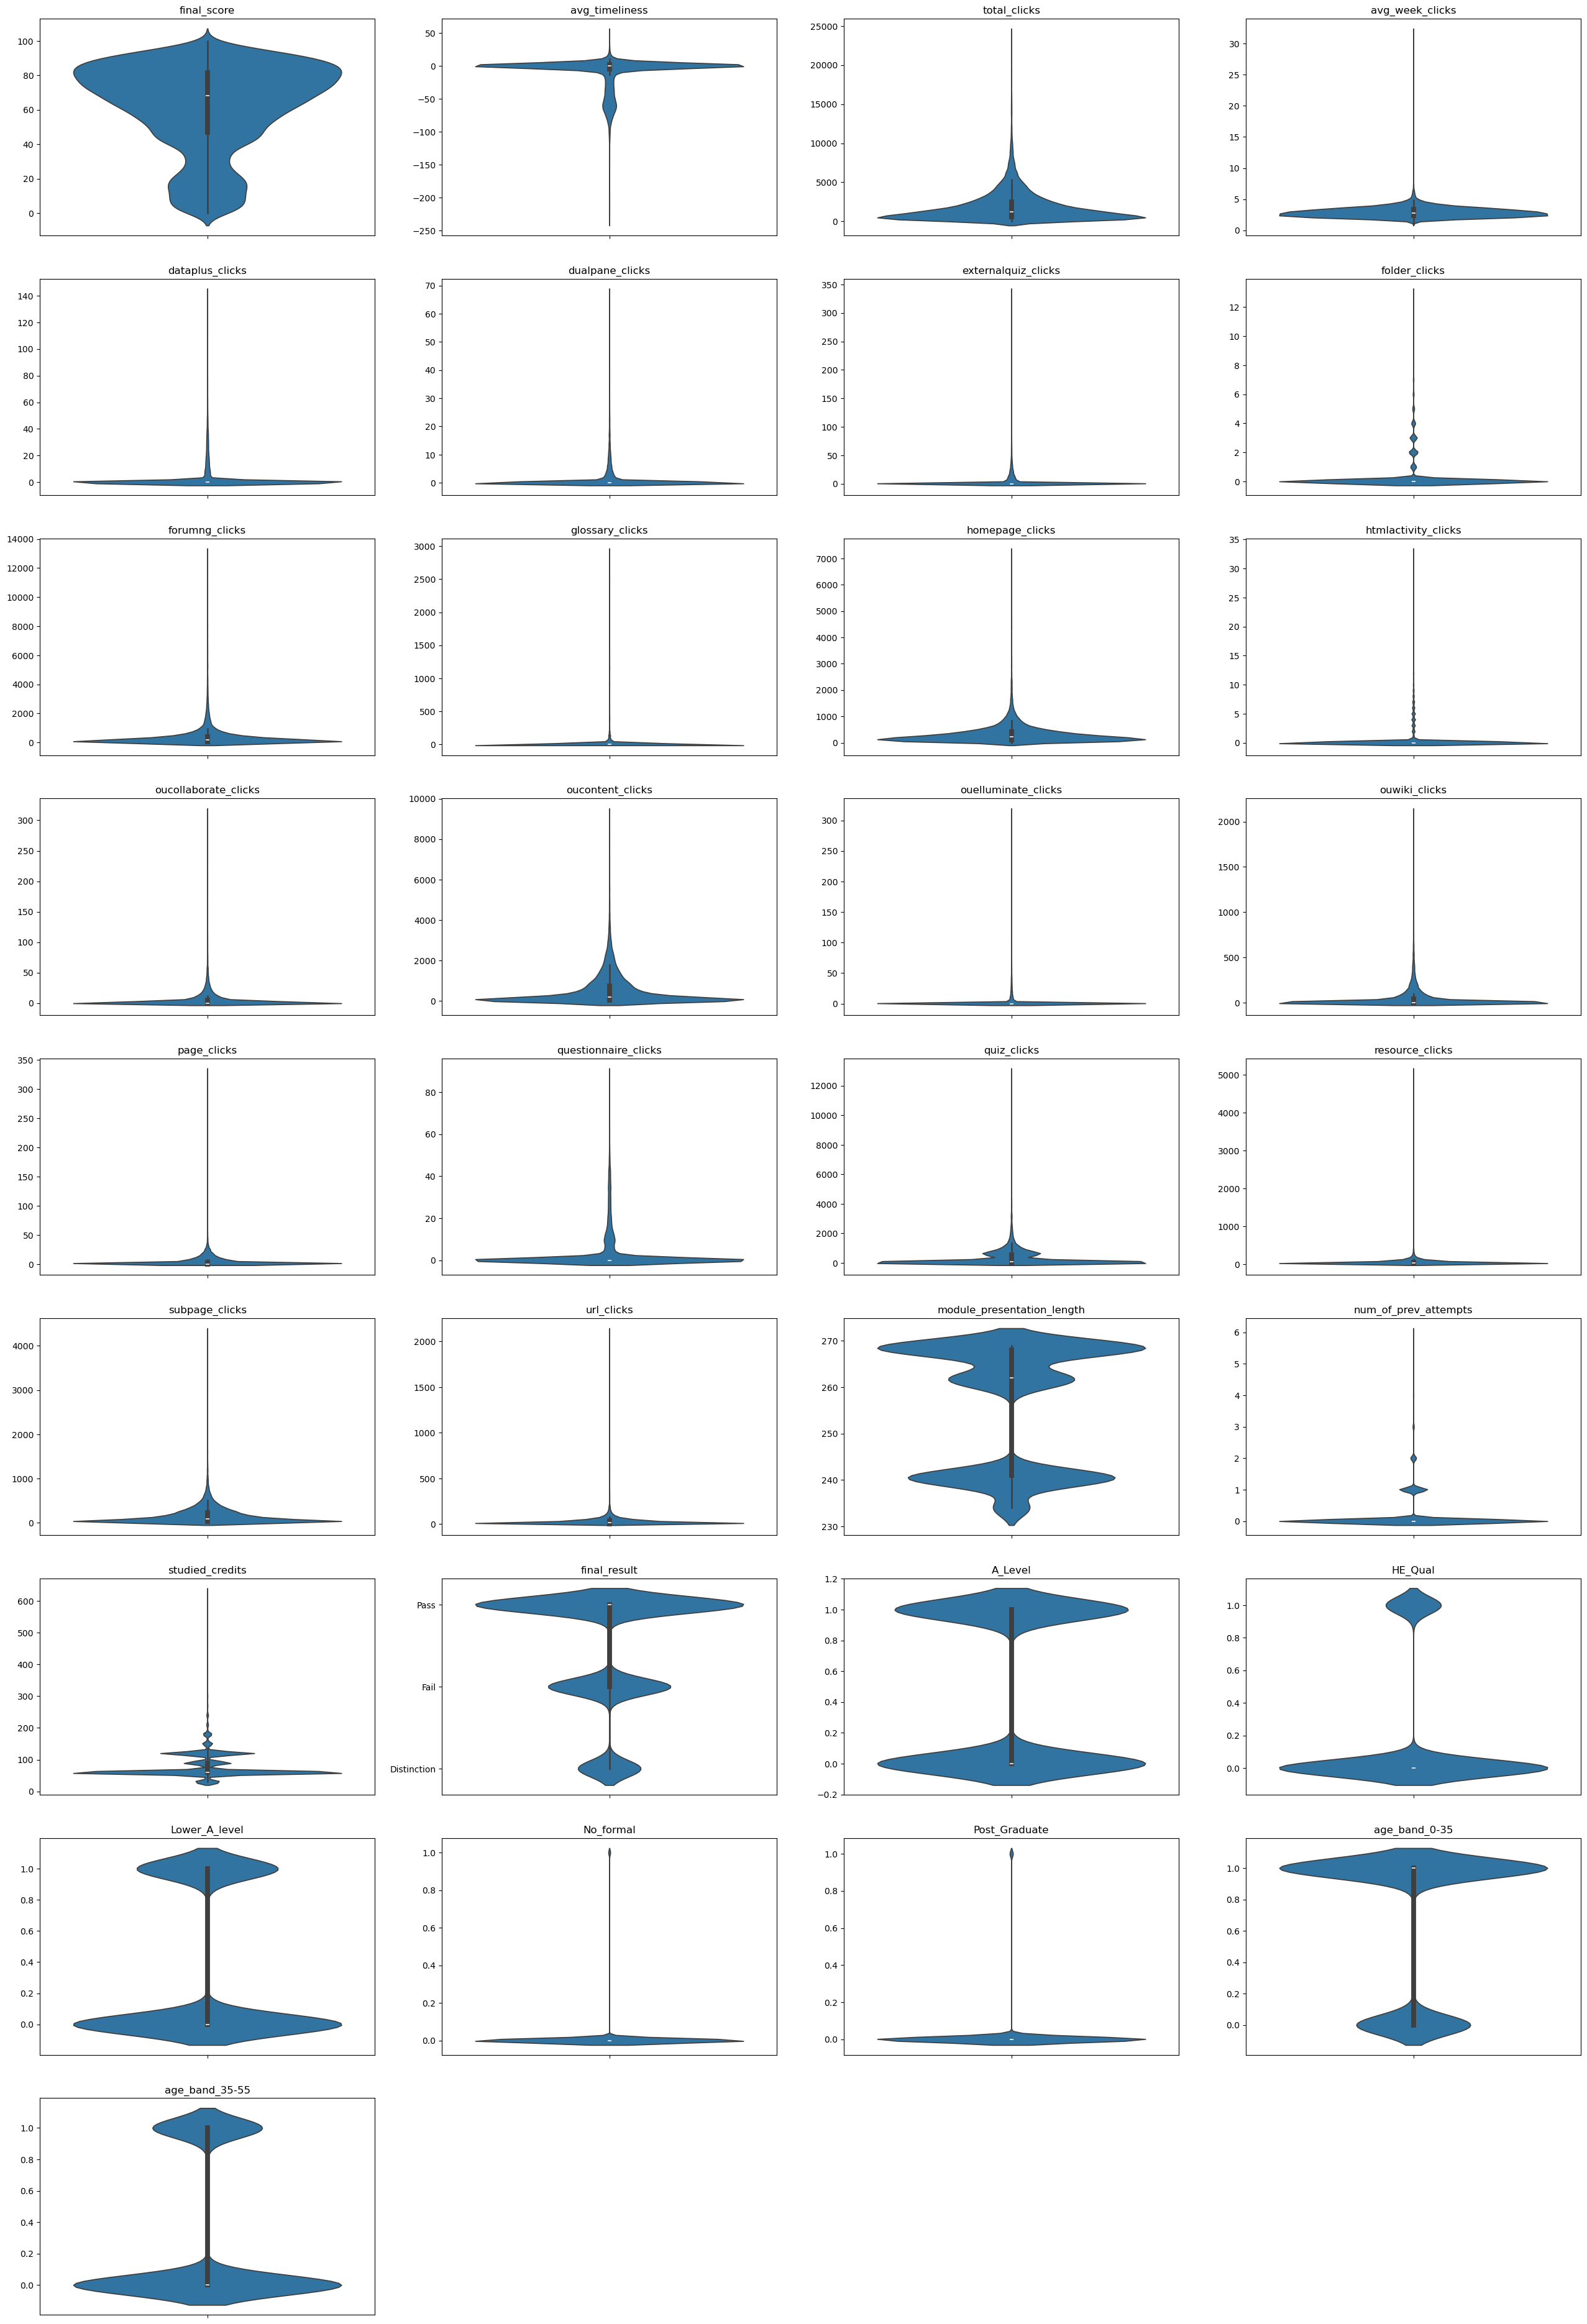

In [121]:
fig, axes = plt.subplots(nrows = 9, ncols = 4)
axes = axes.flatten()

for col, ax in zip(merged_df.iloc[:,3:37].columns,axes.flat):
    sns.violinplot(merged_df.iloc[:,3:37],y=col,ax=ax)
    ax.set_ylabel("")
    ax.set_title(col)
    
for i in range(len(merged_df.iloc[:,3:37].columns), len(axes)):
    fig.delaxes(axes[i])

fig.set_figwidth(fig.get_figwidth() * 5)
fig.set_figheight(fig.get_figheight() * 10)

#### 3_10: Perform Scatter plot Clicks vs Scores on all the data

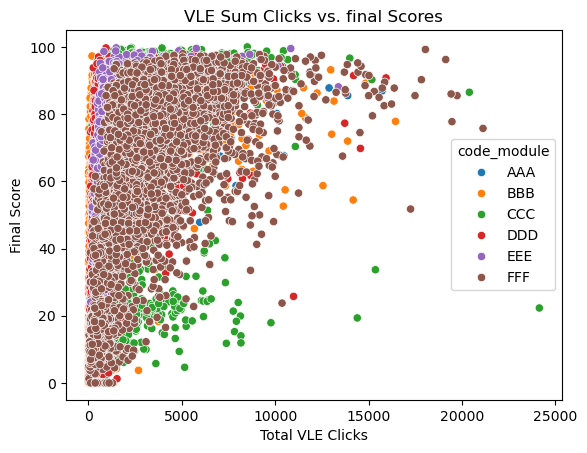

In [123]:
sns.scatterplot(data=merged_df_visualization, x='total_clicks', y='final_score',hue='code_module') #, hue='final_result'
plt.title('VLE Sum Clicks vs. final Scores')
plt.xlabel('Total VLE Clicks')
plt.ylabel('Final Score')
plt.show()

#### 3_10_1: Scatter Plot for module FFF_2013J (we use this data set for modelling)
for the rest of module/presentation combinations it can be choosen from the list bellow and do the modeling

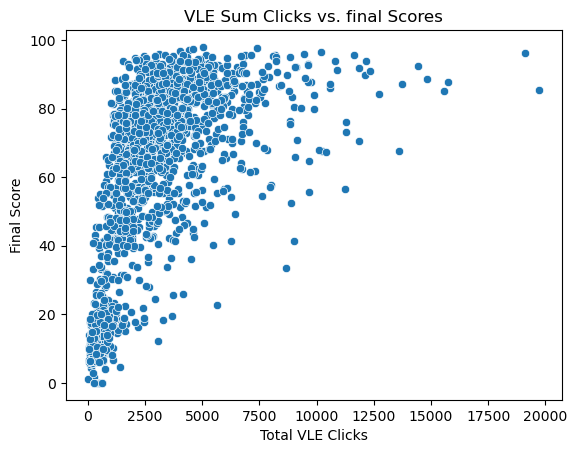

In [272]:
dataset_AAA = merged_df[merged_df['code_module'] == 'AAA']
dataset_BBB = merged_df[merged_df['code_module'] == 'BBB']
dataset_CCC = merged_df[merged_df['code_module'] == 'CCC']
dataset_DDD = merged_df[merged_df['code_module'] == 'DDD']
dataset_EEE = merged_df[merged_df['code_module'] == 'EEE']
dataset_FFF = merged_df[merged_df['code_module'] == 'FFF']

#################################################
# Change the module/presention desired to model in here
Module = dataset_FFF
Presentation = '2013J'
#################################################


M_P_chosen_df= Module[Module['code_presentation']== Presentation]


sns.scatterplot(data=M_P_chosen_df, x='total_clicks', y='final_score') #hue 
plt.title('VLE Sum Clicks vs. final Scores')
plt.xlabel('Total VLE Clicks')
plt.ylabel('Final Score')
plt.show()

Removing final_result(pass/fail/withrawn) column from the datset

In [274]:
M_P_chosen_df = M_P_chosen_df.drop(columns=['final_result'])

### 3-12: Calculuate the skew of each feature

In [276]:
skewness = M_P_chosen_df.iloc[:,3:35].skew()
skewness

final_score                   -0.834671
avg_timeliness                -0.674713
total_clicks                   1.731273
avg_week_clicks                0.518666
dataplus_clicks                2.202144
dualpane_clicks                1.892491
externalquiz_clicks            0.000000
folder_clicks                  1.159178
forumng_clicks                 5.449689
glossary_clicks               32.312503
homepage_clicks                3.370860
htmlactivity_clicks            0.000000
oucollaborate_clicks           2.919112
oucontent_clicks               1.474834
ouelluminate_clicks            0.000000
ouwiki_clicks                  3.623814
page_clicks                    1.642412
questionnaire_clicks           1.243066
quiz_clicks                    2.555080
resource_clicks               23.509169
subpage_clicks                 1.594006
url_clicks                     2.427834
module_presentation_length     0.000000
num_of_prev_attempts           3.569182
studied_credits                1.821262


In [278]:
skew_threshold = 1

skewed_columns = skewness[skewness.abs() > skew_threshold].index.tolist()

we can see that som skew values of the features range widely and some of them are highly skewed. This can affect the performance of linear regression. Linear regression assume that predictors have normal distribution or at least are symmetrically distributed. The response variable(final_score), has a moderate skew=-0.83

#### 3_12_1: Apply Transformations to Skewed Predictors 

In [289]:

# transform skewed features
df_transformed =M_P_chosen_df.iloc[:,3:35].copy()

for col in skewed_columns:
    if df_transformed[col].min() > 0:  # Ensure no zero values for log then Log transformation for positive skewed columns
        df_transformed[col] = np.log(df_transformed[col] + 1)  # Log transform (shift by 1 if necessary)
    else:
        
        pt = PowerTransformer(method='yeo-johnson') # Yeo-Johnson transformation for columns with zeros or negative values, we have zero values
        df_transformed[col] = pt.fit_transform(df_transformed[[col]])

# Standardizing the transformed features with StandardScaler
scaler = StandardScaler()
df_transformed[skewed_columns] = scaler.fit_transform(df_transformed[skewed_columns])

after above transformation the kurtosis also checked:  
**Observations from the Kurtosis Results:**  

Leptokurtic(High Kurtosis > 3):  
homepage_clicks, ouwiki_clicks, oucollaborate_clicks, num_of_prev_attempts, No_formal, and Post_Graduate,
url_clicks, studied_credits, and quiz_clicks

Platykurtic Features (Negative Kurtosis < 0): 
A_Level, Lower_A_level, age_band_0-35, and age_band_35-55

# Step 4 : Modeling 

### 4-1: Hypothesis testing :

#### 4-1-1 Pearson r

 Null hypothesis (H0): There is no relationship between total_clicks and final_score.   
Alternative hypothesis (H1): There is a relationship between total_clicks and final_score.

To test the hypothesis of whether there is a relationship between total_clicks and final_score, we perform a statistical hypothesis test such as Pearson's correlation test, which measures the strength and direction of the linear relationship between two continuous variables.

In [291]:
from scipy.stats import pearsonr

# Select the relevant columns
total_clicks = merged_df['total_clicks']
final_score = merged_df['final_score']


correlation, p_value = pearsonr(total_clicks, final_score) # Perform Pearson's correlation test


print(f'Pearson Correlation Coefficient: {correlation}')
print(f'P-value: {p_value}')


if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant relationship between total_clicks and final_score.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between total_clicks and final_score.")


Pearson Correlation Coefficient: 0.41065538315947764
P-value: 0.0
Reject the null hypothesis: There is a significant relationship between total_clicks and final_score.


#### 4-1_2: ANOVA

first we plot a box plot to show that there is relationship between score level and sum of clicks then do a hypothesis test

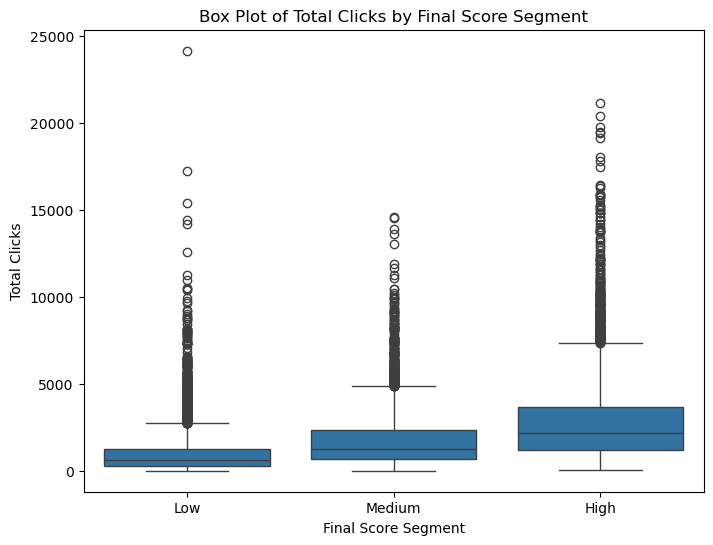

In [198]:

bins = [0, 60, 75, 100]  
labels = ['Low', 'Medium', 'High']

merged_df['score_segment'] = pd.cut(merged_df['final_score'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(8, 6))
sns.boxplot(x='score_segment', y='total_clicks', data=merged_df)

plt.xlabel('Final Score Segment')
plt.ylabel('Total Clicks')
plt.title('Box Plot of Total Clicks by Final Score Segment')

plt.show()


Null hypothesis (H0): There is no significant difference in total_clicks between the different final_score segments.   
Alternative hypothesis (H1): There is a significant difference in total_clicks between the different final_score segments.

In [146]:
from scipy.stats import f_oneway

bins = [0, 60, 75, 100]  # score ranges: low, medium, high
labels = ['Low', 'Medium', 'High']


merged_df['score_segment'] = pd.cut(merged_df['final_score'], bins=bins, labels=labels, right=False)


low_clicks = merged_df[merged_df['score_segment'] == 'Low']['total_clicks']
medium_clicks = merged_df[merged_df['score_segment'] == 'Medium']['total_clicks']
high_clicks = merged_df[merged_df['score_segment'] == 'High']['total_clicks']


f_stat, p_value = f_oneway(low_clicks, medium_clicks, high_clicks)

print(f'ANOVA F-statistic: {f_stat}')
print(f'P-value: {p_value}')

# Interpretation of results
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in total_clicks across the final_score segments.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in total_clicks across the final_score segments.")


ANOVA F-statistic: 1696.941097161641
P-value: 0.0
Reject the null hypothesis: There is a significant difference in total_clicks across the final_score segments.


### 4-2: More data processing, choosing a subset of data () and Linear regression

When performing  linear regression we should consider:  
1- multicollinearity among the features  
2- Model selection: what polynomial terms do needed
and Hypothesis testing on the parameters  
3- Goodness of fit  
•do features can predict the response (in sample)?    
After this, we:  
     •Obtain confidence intervals on the parameters  
     •Interpret the parameters to provide insight  
     •Produce a prediction interval of the response  
     •out-of-sample forecast  

### 4-3 : Investigate multicollinearity among features

In [ ]:
##### Alternative way to choose feature with multiculinearity (setting a threshold rho>0.7)
############################################################################################
# numeric_cols = df_transformed.iloc[:, 4:35]

# correlation_matrix = numeric_cols.corr()
# correlation_matrix = correlation_matrix.fillna(0)
# # Set threshold to detect multicollinearity
# threshold = 0.7

# highly_correlated = set()

# for i in range(len(correlation_matrix.columns)):
#     for j in range(i):
#         if abs(correlation_matrix.iloc[i, j]) > threshold  :
#             colname = correlation_matrix.columns[i]
#             highly_correlated.add(colname)

# print(" Multicollinearity features to be removed are:", highly_correlated)
# df_transformed_cleaned = df_transformed.drop(columns=highly_correlated)

In [ ]:
# 𝑯𝟎: 𝜌 = 0
# 𝑯𝟏: 𝜌 > 0
numeric_cols = df_transformed.iloc[:, 4:35] # df_transformed is the data set after Applying Transformations to Skewed Predictors

alpha = 0.05 
for idx, col in enumerate(numeric_cols.columns[:-1]):
    for col2 in numeric_cols.columns[idx:-1]:
        if (numeric_cols[col].dtype == np.float64) and (numeric_cols[col2].dtype == np.float64):
            res = pearsonr(numeric_cols[col],numeric_cols[col2],method=PermutationMethod())
            if res.pvalue > alpha:
                print(f" failed to reject the null hypothesis for the correlation between {col} and {col2}")
# no output here implies all correlations are significant

The results indicate that for the specified feature pairs, the null hypothesis(no correlation) could not be rejected. This means there is insufficient evidence to suggest these feature pairs are significantly correlated at 0.05 significance level.

It is decided to remove these features: glossary_clicks, No_formal, Post_Graduate,

In [296]:
highly_correlated = ['glossary_clicks', 'No_formal', 'Post_Graduate']
df_transformed_cleaned = df_transformed.drop(columns=highly_correlated)

In [298]:
correlation_matrix = numeric_cols.corr()
correlation_matrix = correlation_matrix.fillna(0)
correlation_matrix

,dataplus_clicks,dualpane_clicks,externalquiz_clicks,folder_clicks,forumng_clicks,glossary_clicks,homepage_clicks,htmlactivity_clicks,oucollaborate_clicks,oucontent_clicks,ouelluminate_clicks,ouwiki_clicks,page_clicks,questionnaire_clicks,quiz_clicks,resource_clicks,subpage_clicks,url_clicks,module_presentation_length,num_of_prev_attempts,studied_credits,A_Level,HE_Qual,Lower_A_level,No_formal,Post_Graduate,age_band_0-35,age_band_35-55
dataplus_clicks,1.000000,0.669449,0.0,0.371796,0.438750,0.093084,0.554840,0.0,0.295573,0.611514,0.0,0.555042,0.580220,0.689029,0.429221,0.449975,0.565007,0.623285,0.0,-0.083550,-0.097139,0.002169,0.087677,-0.058449,-0.028243,-0.027784,-0.184917,0.183651
dualpane_clicks,0.669449,1.000000,0.0,0.331454,0.532923,0.152896,0.639214,0.0,0.326347,0.704015,0.0,0.711393,0.636148,0.801791,0.424825,0.517683,0.640628,0.683227,0.0,-0.094796,-0.104661,-0.017590,0.058318,-0.023749,-0.017454,0.008171,-0.221765,0.217919
externalquiz_clicks,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
folder_clicks,0.371796,0.331454,0.0,1.000000,0.417498,0.088569,0.589789,0.0,0.293791,0.606511,0.0,0.353351,0.337529,0.347490,0.661012,0.506246,0.635924,0.529167,0.0,-0.092217,-0.001530,0.077126,0.006921,-0.089877,0.068907,-0.029584,-0.059265,0.058281
forumng_clicks,0.438750,0.532923,0.0,0.417498,1.000000,0.211782,0.822597,0.0,0.454743,0.645025,0.0,0.656169,0.597356,0.563178,0.549734,0.555374,0.725256,0.697204,0.0,-0.142430,-0.050960,-0.009997,0.064101,-0.041333,0.023446,0.004505,-0.241327,0.226242
glossary_clicks,0.093084,0.152896,0.0,0.088569,0.211782,1.000000,0.213880,0.0,0.105766,0.166637,0.0,0.181979,0.200367,0.144819,0.150656,0.189889,0.220075,0.235273,0.0,-0.040421,0.014723,-0.059874,0.048803,0.026385,-0.001500,-0.004956,-0.052477,0.049375
homepage_clicks,0.554840,0.639214,0.0,0.589789,0.822597,0.213880,1.000000,0.0,0.466560,0.858146,0.0,0.704689,0.679149,0.661176,0.707849,0.701689,0.910820,0.827033,0.0,-0.132798,-0.002760,0.024059,0.050887,-0.065206,0.020820,-0.001348,-0.197632,0.188448
htmlactivity_clicks,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
oucollaborate_clicks,0.295573,0.326347,0.0,0.293791,0.454743,0.105766,0.466560,0.0,1.000000,0.399144,0.0,0.418687,0.417150,0.339367,0.332547,0.397258,0.458371,0.460341,0.0,-0.070381,-0.064356,-0.031513,0.011698,0.017445,0.028759,0.012462,-0.179923,0.166551
oucontent_clicks,0.611514,0.704015,0.0,0.606511,0.645025,0.166637,0.858146,0.0,0.399144,1.000000,0.0,0.714516,0.662209,0.717889,0.704088,0.654186,0.895691,0.798802,0.0,-0.135545,-0.055327,0.014160,0.057091,-0.063001,0.041022,0.000927,-0.162764,0.162115


### 4_4: Feature selection

In [300]:
#Split the data into response and predictor
X = df_transformed_cleaned.iloc[:, 4:35]  # features
y = df_transformed_cleaned['final_score']   # response variable


#### 4_4_1: For all possible number of features, find out the Score and Features chosen using RFE

In [236]:
# For all possible number of features, find out the Score and Features chosen using RFE

num_features = [1,2,3,4,5,6,7,8,9,10]
lm = LinearRegression()

rfe_features = {nf : {} for nf in num_features}

for nf in num_features:
    rfe = RFE(lm,n_features_to_select=nf).fit(X,y)
    rfe_features[nf] = {"score":rfe.score(X,y), "features": rfe.get_feature_names_out()}

print(rfe_features)

{1: {'score': 0.008798473528990991, 'features': array(['age_band_35-55'], dtype=object)}, 2: {'score': 0.00896255499042553, 'features': array(['age_band_0-35', 'age_band_35-55'], dtype=object)}, 3: {'score': 0.3251209210085231, 'features': array(['forumng_clicks', 'age_band_0-35', 'age_band_35-55'], dtype=object)}, 4: {'score': 0.4128170540097714, 'features': array(['forumng_clicks', 'resource_clicks', 'age_band_0-35',
       'age_band_35-55'], dtype=object)}, 5: {'score': 0.42977405666844903, 'features': array(['forumng_clicks', 'resource_clicks', 'num_of_prev_attempts',
       'age_band_0-35', 'age_band_35-55'], dtype=object)}, 6: {'score': 0.4409002175184932, 'features': array(['forumng_clicks', 'resource_clicks', 'num_of_prev_attempts',
       'A_Level', 'age_band_0-35', 'age_band_35-55'], dtype=object)}, 7: {'score': 0.4487110765720832, 'features': array(['forumng_clicks', 'resource_clicks', 'num_of_prev_attempts',
       'A_Level', 'HE_Qual', 'age_band_0-35', 'age_band_35-55'],
 

#### 4_4_2: For all possible number of features, find out the Score and Features chosen using Sequential Feature Selector (Forward)

In [238]:
#For all possible number of features, find out the Score and Features chosen using Sequential Feature Selector (Forward)


sfs_features = {nf : {} for nf in num_features[:-1]}

for nf in num_features[:-1]:
    sfs = SequentialFeatureSelector(lm,n_features_to_select=nf).fit(X,y)
    features = sfs.get_feature_names_out()
    new_X = X[features]
    score = lm.fit(new_X,y).score(new_X,y)
    sfs_features[nf] = {"score":score, "features": features}

print(sfs_features)

{1: {'score': 0.3427041110405078, 'features': array(['total_clicks'], dtype=object)}, 2: {'score': 0.4059022902221955, 'features': array(['total_clicks', 'resource_clicks'], dtype=object)}, 3: {'score': 0.44094463483665836, 'features': array(['total_clicks', 'folder_clicks', 'resource_clicks'], dtype=object)}, 4: {'score': 0.4624120404494676, 'features': array(['total_clicks', 'folder_clicks', 'forumng_clicks',
       'resource_clicks'], dtype=object)}, 5: {'score': 0.48101631962615543, 'features': array(['total_clicks', 'folder_clicks', 'forumng_clicks',
       'oucontent_clicks', 'resource_clicks'], dtype=object)}, 6: {'score': 0.5083263730093315, 'features': array(['total_clicks', 'folder_clicks', 'forumng_clicks',
       'oucontent_clicks', 'quiz_clicks', 'resource_clicks'], dtype=object)}, 7: {'score': 0.525054868349619, 'features': array(['total_clicks', 'folder_clicks', 'forumng_clicks',
       'oucontent_clicks', 'quiz_clicks', 'resource_clicks',
       'Lower_A_level'], dtype=

In [240]:
print(sfs.get_feature_names_out())
new_X = X[sfs.get_feature_names_out()]
print(lm.fit(new_X,y).score(new_X,y))

['total_clicks' 'folder_clicks' 'forumng_clicks' 'oucollaborate_clicks'
 'oucontent_clicks' 'quiz_clicks' 'resource_clicks' 'subpage_clicks'
 'Lower_A_level']
0.5474009067280481


In [244]:
sfs = SequentialFeatureSelector(lm,direction="backward",n_features_to_select=2).fit(X,y)
print(sfs.get_feature_names_out())
new_X = X[sfs.get_feature_names_out()]
print(lm.fit(new_X,y).score(new_X,y))

['folder_clicks' 'forumng_clicks']
0.41359738442188576


In [246]:
tols = [0.1, 0.01, 0.001]

for tol in tols:
    sfs = SequentialFeatureSelector(lm,tol=tol).fit(X,y)
    print(f"Tolerance: {tol}")
    print(f"Features chosen: {sfs.get_feature_names_out()}")
    new_X = X[sfs.get_feature_names_out()]
    print(f"Score: {lm.fit(new_X,y).score(new_X,y)}")
    print("\n")

Tolerance: 0.1
Features chosen: ['total_clicks']
Score: 0.3427041110405078


Tolerance: 0.01
Features chosen: ['total_clicks' 'folder_clicks' 'forumng_clicks' 'oucollaborate_clicks'
 'oucontent_clicks' 'quiz_clicks' 'resource_clicks' 'subpage_clicks'
 'Lower_A_level']
Score: 0.5474009067280481


Tolerance: 0.001
Features chosen: ['avg_timeliness' 'total_clicks' 'avg_week_clicks' 'folder_clicks'
 'forumng_clicks' 'homepage_clicks' 'oucollaborate_clicks'
 'oucontent_clicks' 'page_clicks' 'questionnaire_clicks' 'quiz_clicks'
 'resource_clicks' 'subpage_clicks' 'num_of_prev_attempts' 'Lower_A_level']
Score: 0.5779903266246215




**Interpretation:**  
From tol=0.1 to tol=0.01, the score improves significantly.(34% to 0.54%)  
From tol=0.01 to tol=0.001, the improvement is less than before(0.54% to 57%), and model selects nine features (compared to 5). 
because we need our model for interpretation not performance, it is decided to **choose Tolerance: 0.001 with nine features.** 

In [248]:
#Linear Regression using statsmodels

model = sm.OLS.from_formula("final_score ~ avg_timeliness + total_clicks  + avg_week_clicks + folder_clicks + forumng_clicks +\
                         homepage_clicks + oucollaborate_clicks + oucontent_clicks + page_clicks+ questionnaire_clicks+\
                         quiz_clicks+subpage_clicks+num_of_prev_attempts+Lower_A_level" ,data=df_transformed_cleaned)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            final_score   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     131.0
Date:                Mon, 13 Jan 2025   Prob (F-statistic):          1.84e-248
Time:                        01:31:53   Log-Likelihood:                -6519.8
No. Observations:                1522   AIC:                         1.307e+04
Df Residuals:                    1507   BIC:                         1.315e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                61.1435      2.698     22.665      0.000      55.852      66.435
Lower_A_level[T.True]    -6.2868      0.935     -6.720      0.000      -8.122      -4.452
avg_timeliness           -0.0421      0.016     -2.577      0.010      -0.074      -0.010
total_clicks             -0.0069      0.001     -5.506      0.000      -0.009      -0.004
avg_week_clicks          -3.4655      0.870     -3.984      0.000      -5.172      -1.759
folder_clicks             3.0698      0.283     10.845      0.000       2.515       3.625
forumng_clicks           10.9704      0.810     13.545      0.000       9.382      12.559
homepage_clicks           0.0120      0.003      3.518      0.000       0.005       0.019
oucollaborate_clicks     -0.3200      0.066     -4.825      0.000      -0.450      -0.190
oucontent_clicks          0.0151      0.001     10.235      0.000       0.012       0.018
page_clicks              -0.2911      0.086     -3.403      0.001      -0.459      -0.123
questionnaire_clicks      0.2892      0.055      5.223      0.000       0.181       0.398
quiz_clicks               0.0168      0.002     10.154      0.000       0.014       0.020
subpage_clicks           -0.0115      0.006     -1.903      0.057      -0.023       0.000
num_of_prev_attempts     -7.0948      1.134     -6.259      0.000      -9.318      -4.871
==============================================================================
Omnibus:                       33.533   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.434
Skew:                          -0.238   Prob(JB):                     1.82e-06
Kurtosis:                       2.565   Cond. No.                     2.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [202]:
num_features = 9
lm = LinearRegression()
sfs = SequentialFeatureSelector(lm,n_features_to_select=num_features).fit(X,y)

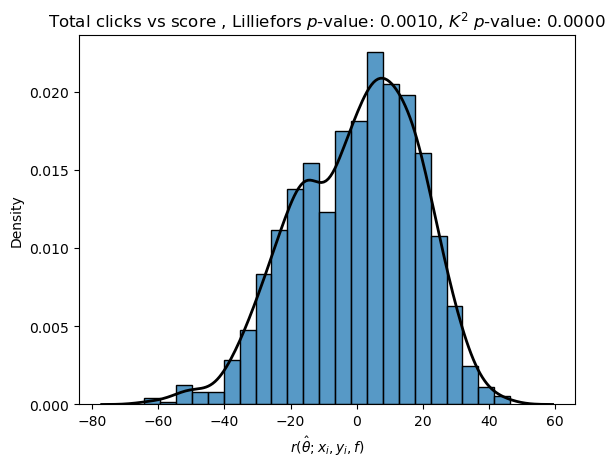

In [210]:


pred_mean = result.fittedvalues
residual = df_transformed_cleaned["final_score"] - pred_mean 

fig, ax = plt.subplots(nrows=1,ncols=1)

sns.histplot(residual,ax=ax, stat="density")
sns.kdeplot(residual,lw=2,color="k",ax=ax)
ax.set_xlabel(r"$r(\hat{\theta}; x_i,y_i,f)$")

_, l_p_value = lilliefors(residual, dist="norm")
_, k_p_value = normaltest(residual)

_ = ax.set_title(f"Total clicks vs score , Lilliefors $p$-value: {l_p_value:.4f}, $K^2$ $p$-value: {k_p_value:.4f}")

Normality of residuals is one of the key assumptions for linear regression. If residuals are not normally distributed, it can affect the efficiency of estimates and lead to biased predictions.

In [ ]:
pred_mean = result.fittedvalues
pred_ols = result.get_prediction()
pred_lb = pred_ols.summary_frame(alpha=0.05)["obs_ci_lower"]
pred_ub = pred_ols.summary_frame(alpha=0.05)["obs_ci_upper"]

fig, ax = plt.subplots(nrows=1,ncols=1)

x = oh_df["engine_volume_L"].sort_values(inplace=False)
y = np.sort(pred_mean)
lb = np.sort(pred_lb)
ub = np.sort(pred_ub)

ax.plot(x, y, ls="--", color="k", label="OLS")
ax.fill_between(x,lb,ub,color="lightgray",label="95% PI")
ax.scatter(oh_df["engine_volume_L"], oh_df["horsepower"], marker="x", color="r", label="data")
ax.set_xlabel("engine volume (L)")
ax.set_ylabel("horsepower")
ax.set_title(r"Prediction interval using $statsmodels$")
_ = ax.legend(loc="best")

(Coefficient of Determination) measures the proportion of variance in the dependent variable (y) that is explained by the independent variables (X).  

• for our case Only 20% of the variance in is explained by the model, and 80% remains unexplained.

a possible causes of low R2 is that the relationship between the features and target may not be linear.therefore we may try non-linear models (e.g., polynomial regression, decision trees). Or may be important features influencing the target variable might be absent.

Also we can improving data quality by removing outliers.High Variance in the Target Variable

• If the target variable () is influenced by factors outside the dataset, then R2 naturally is low and we have to accept that some processes are inherently complex and unpredictable, hence we focus on actionable insights rather than high R2 .


 R²=0.49 indicates that model explains almost half of the variance in the final_score. (moderate fit)
 In real word problem that working 